In [102]:
# Packages
import os
import sys
import math
import re
import itertools
import scipy as sp
from scipy.stats import fisher_exact, ttest_ind
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import seaborn as sns

# Check working directory
print('Current working dir:', os.getcwd())

Current working dir: /Users/jakeharris/Documents/GitHub/df-assignment


In [2]:
# Preview sample-info.tsv file
sample_info_path = os.path.join('vanallen-assessment', 'sample-information.tsv')
sample_info_df = pd.read_csv(sample_info_path, sep='\t')
print(sample_info_df.columns)
print('Number of patient entries:', len(sample_info_df))
sample_info_df.head()

Index(['Patient_ID', 'Tumor_Sample_Barcode', 'Matched_Norm_Sample_Barcode',
       'Response', 'Silent_mutations_per_Mb', 'Nonsynonymous_mutations_per_Mb',
       'Mutations_per_Mb'],
      dtype='object')
Number of patient entries: 50


,Patient_ID,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Response,Silent_mutations_per_Mb,Nonsynonymous_mutations_per_Mb,Mutations_per_Mb
0,Patient-0,Patient-0-Tumor,Patient-0-Normal,Non-Responder,2.87,6.77,9.64
1,Patient-1,Patient-1-Tumor,Patient-1-Normal,Responder,1.92,6.14,8.06
2,Patient-2,Patient-2-Tumor,Patient-2-Normal,Responder,1.32,2.84,4.16
3,Patient-3,Patient-3-Tumor,Patient-3-Normal,Non-Responder,1.78,5.00,6.78
4,Patient-4,Patient-4-Tumor,Patient-4-Normal,Responder,4.93,10.50,15.43


In [3]:
# Preview Patient 0 mutation .maf file
patient0_path = os.path.join('vanallen-assessment', 'mafs', 'Patient-0.somatic.snvs.maf')
patient0_df = pd.read_csv(patient0_path, sep='\t')
print(patient0_df.columns)
print('Number of annotation rows for Patient 0:', len(patient0_df))
patient0_df.head()

Index(['Hugo_Symbol', 'Chromosome', 'Start_position', 'End_position',
       'Variant_Classification', 'Variant_Type', 'Reference_Allele',
       'Tumor_Seq_Allele1', 'Tumor_Seq_Allele2', 'Tumor_Sample_Barcode',
       'Matched_Norm_Sample_Barcode', 'Protein_Change', 't_alt_count',
       't_ref_count'],
      dtype='object')
Number of annotation rows for Patient 0: 334


,Hugo_Symbol,Chromosome,Start_position,End_position,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Protein_Change,t_alt_count,t_ref_count
0,AMOT,X,112035152,112035152,Missense_Mutation,SNP,G,G,C,Patient-0-Tumor,Patient-0-Normal,p.Q612E,8,31
1,SEMA6D,15,48062786,48062786,Missense_Mutation,SNP,G,G,A,Patient-0-Tumor,Patient-0-Normal,p.A676T,4,87
2,PRR12,19,50100969,50100969,Missense_Mutation,SNP,C,C,G,Patient-0-Tumor,Patient-0-Normal,p.S1126C,5,25
3,TNR,1,175372529,175372529,Silent,SNP,G,G,A,Patient-0-Tumor,Patient-0-Normal,p.S241S,30,155
4,CPA4,7,129944344,129944344,Silent,SNP,C,C,G,Patient-0-Tumor,Patient-0-Normal,p.A137A,12,100


In [4]:
# Load in all patient .maf data as single dataframe
maf_dir = os.listdir(os.path.join('vanallen-assessment', 'mafs'))  # patient .maf data folder
mutations_df = pd.DataFrame()  # blank DF for later concatenation
for item in maf_dir:
    patient_df = pd.read_csv(os.path.join('vanallen-assessment', 'mafs', item), sep='\t')
    mutations_df = pd.concat([mutations_df, patient_df], ignore_index=True)
print('Number of annotation rows for all patients:', len(mutations_df))
# mutations_df.head()

# Merge mutations_df and sample_info_df on common columns
merged_df = mutations_df.merge(sample_info_df, how='left', on=['Tumor_Sample_Barcode', 'Matched_Norm_Sample_Barcode'])
print('Number of entries in merged_df:', len(merged_df))

# Filter out silent mutations from variant_classification column
print('Mutation variant types:', merged_df['Variant_Classification'].unique())
nonsynon_df = merged_df[merged_df['Variant_Classification'] != 'Silent']  # nonsynonymous mutations df
print('Number of nonsynonymous mutations:', len(nonsynon_df))
nonsynon_df.head()

Number of annotation rows for all patients: 15673
Number of entries in merged_df: 15673
Mutation variant types: ['Missense_Mutation' 'Silent' 'Nonsense_Mutation' 'Splice_Site']
Number of nonsynonymous mutations: 11247


,Hugo_Symbol,Chromosome,Start_position,End_position,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Protein_Change,t_alt_count,t_ref_count,Patient_ID,Response,Silent_mutations_per_Mb,Nonsynonymous_mutations_per_Mb,Mutations_per_Mb
0,CEP350,1,180063656,180063656,Missense_Mutation,SNP,G,G,A,Patient-36-Tumor,Patient-36-Normal,p.E2806K,12,28,Patient-36,Responder,2.47,6.0,8.47
1,CCDC88C,14,91739009,91739009,Missense_Mutation,SNP,C,C,T,Patient-36-Tumor,Patient-36-Normal,p.G2016E,36,57,Patient-36,Responder,2.47,6.0,8.47
2,KDM6B,17,7749509,7749509,Missense_Mutation,SNP,A,A,T,Patient-36-Tumor,Patient-36-Normal,p.Y117F,4,25,Patient-36,Responder,2.47,6.0,8.47
3,PGAP1,2,197781268,197781268,Missense_Mutation,SNP,G,G,C,Patient-36-Tumor,Patient-36-Normal,p.F117L,11,25,Patient-36,Responder,2.47,6.0,8.47
4,PARD6B,20,49366765,49366765,Missense_Mutation,SNP,G,G,C,Patient-36-Tumor,Patient-36-Normal,p.E287Q,21,88,Patient-36,Responder,2.47,6.0,8.47


In [5]:
# Find the 15 most common MT genes (regardless of multiple MT gene occurrence in same patient)
top15_MTgenes = nonsynon_df[['Hugo_Symbol']].value_counts(dropna=False).to_frame('MT_Count').reset_index()
top15_MTgenes.head(15)

,Hugo_Symbol,MT_Count
0,TTN,41
1,TP53,30
2,ERBB4,27
3,SPEN,22
4,MUC16,22
5,KMT2C,20
6,KMT2D,17
7,ERBB3,16
8,FRG1B,14
9,ZNF91,13


In [6]:
# Find the 15 most common specific mutations
### NOTE: accounting for NaN values unique to splice_site variants yields different results
for variant in nonsynon_df['Variant_Classification'].unique():
    nan_check = nonsynon_df[nonsynon_df['Variant_Classification']==variant].isnull().values.any()
    print(variant, nan_check)  # check for NaN values in variant_classifications
print('Number of splice_site mutations:', len(nonsynon_df[nonsynon_df['Variant_Classification']=='Splice_Site']))  # 392 splice_site MT variants
print('Number of splice_site NaN variants:', nonsynon_df['Protein_Change'].isnull().sum())  # 209 splice_site NaNs MT variants

Missense_Mutation False
Nonsense_Mutation False
Splice_Site True
Number of splice_site mutations: 392
Number of splice_site NaN variants: 209


In [7]:
# Not accounting for splice_site variant classification (drop NaN protein_change values)
# top15_noNan = nonsynon_df[['Hugo_Symbol', 'Variant_Classification', 'Protein_Change']].value_counts().to_frame('Count').reset_index()
# print('Without NaN Variant_Classification values: \n', top15_noNan.head(15))

# Accounting for splice_site variant classification (don't drop NaN protein_change values)
top15_wSplice = nonsynon_df[['Hugo_Symbol', 'Variant_Classification', 'Protein_Change']].value_counts(dropna=False).to_frame('Count').reset_index()
print('With NaN Variant_Classification values:')
top15_wSplice.head(15)

With NaN Variant_Classification values:


,Hugo_Symbol,Variant_Classification,Protein_Change,Count
0,ERBB4,Missense_Mutation,p.S1289A,14
1,ERBB3,Missense_Mutation,p.H228Q,5
2,ERBB4,Missense_Mutation,p.Q707E,5
3,PIK3CA,Missense_Mutation,p.E545K,5
4,TYRO3,Missense_Mutation,p.L819M,4
5,ERBB3,Missense_Mutation,p.M91I,4
6,ERBB4,Missense_Mutation,p.E317K,4
7,RXRA,Missense_Mutation,p.S330F,4
8,MAP2K1,Missense_Mutation,p.F53L,4
9,FAM47C,Missense_Mutation,p.Q225E,4


Mean num. responders mt genes: 291.84
Mean num. non-responders mt genes: 132.2
T-test p-value: 0.00020081134967416667


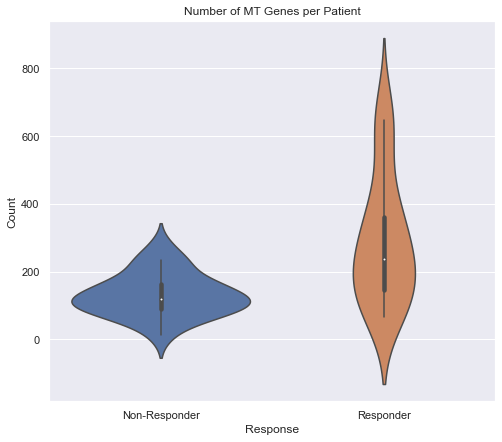

In [200]:
# Run t-test to look at association of mutational burden (total num. of mutations in patient) on response
def response_ttest():
    # setup DF of count of mutant genes per patient
    mt_count_df = nonsynon_df.groupby(['Patient_ID', 'Response'])['Hugo_Symbol'].nunique()
    mt_count_df = mt_count_df.to_frame('Count').reset_index()
    
    # record counts of mt genes per group
    n_mt_genes_resp = [i for i in mt_count_df[mt_count_df['Response']=='Responder']['Count']] # responders
    print('Mean num. responders mt genes:', np.array(n_mt_genes_resp).mean())
    n_mt_genes_non = [i for i in mt_count_df[mt_count_df['Response']=='Non-Responder']['Count']] # non-responders
    print('Mean num. non-responders mt genes:', np.array(n_mt_genes_non).mean())
    
    # T-test to compare mean num. of mt genes between (non-)responders
    tstat, pval = ttest_ind(n_mt_genes_resp, n_mt_genes_non)
    print('T-test p-value:', pval)
    
    # violinplot of results
    sns.set(rc={'figure.figsize': (8,7)})
    sns.violinplot(data=mt_count_df, x='Response', y='Count').set(title='Number of MT Genes per Patient')
    # return plot
    # return np.array(n_mt_genes_resp), np.array(n_mt_genes_non), pval
    
response_ttest()
    

In [86]:
# Check for MT genes which are enriched in responders vs. nonresponders
# 1. check to see if gene listing is only present in patients with nonsynonymous mutation
    ## (num. patients w/ mutation) + (num. patients w/ WT) = 50
# 2. 4 categories:
    ## WT and responder
    ## mutant and responder
    ## WT and nonresponder
    ## mutant and nonresponder
# 3. Run Fisher's exact test on 2x2 contingency table of all genes
    ## WT: wild-type, MT: mutant, R: responder, NR: non-responder
    ##     WT   MT
    ## R
    ## NR

# Function to check for enrichment of MT gene in responders vs. non-responders -- Fisher's exact test
def gene_response_fishers(genes):
    
    # starttime = time.time()
    # Create DF for storing genes/p-values from Fisher's test
    genes_pvalues_df = pd.DataFrame(columns=['Gene', 'P-value', 'MT_Responders', 'MT_Non-Responders', 'WT_Responders', 'WT_Non-Responders'])
     
    # Count 2x2 contingency table of responder/nonresponder vs. wild-type/mutant for each gene
    for gene in tqdm(genes):
        cont_table = np.array([[0, 0], [0, 0]]) # [[WT_responder, MT_responder], [WT_Non, MT_Non]]
        for patient in nonsynon_df['Patient_ID'].unique():
            
            # Responders: check for record of patient MT gene - if not present, assume WT
            if nonsynon_df[(nonsynon_df['Response']=='Responder') & (nonsynon_df['Patient_ID']==patient)]['Response'].any():
                if nonsynon_df[(nonsynon_df['Response']=='Responder') & (nonsynon_df['Patient_ID']==patient)]['Hugo_Symbol'].isin([gene]).any():
                    cont_table[0][1] += 1 # MT_responder (gene present)
                else:
                    cont_table[0][0] += 1 # WT_responder (gene NOT present)
            
            # Non-responders: check for record of patient MT gene - if not present, assume WT
            elif nonsynon_df[(nonsynon_df['Response']=='Non-Responder') & (nonsynon_df['Patient_ID']==patient)]['Response'].any():
                if nonsynon_df[(nonsynon_df['Response']=='Non-Responder') & (nonsynon_df['Patient_ID']==patient)]['Hugo_Symbol'].isin([gene]).any():
                    cont_table[1][1] += 1 # MT_nonresponder
                else:
                    cont_table[1][0] += 1 # WT_nonresponder
    
        # run Fisher's exact test on every gene cont. table, add to genes_pvalues_df
        oddsratio, pvalue = fisher_exact(cont_table)
        new_row = pd.DataFrame([{'Gene': gene, 'P-value': float(pvalue), 'MT_Responders': cont_table[0][1], \
            'MT_Non-Responders': cont_table[1][1], 'WT_Responders': cont_table[0][0], 'WT_Non-Responders': cont_table[1][0], \
            'Total MT Patients': cont_table[0][1] + cont_table[1][1], 'Total WT Patients': cont_table[0][0] + cont_table[1][0]}])
        genes_pvalues_df = pd.concat([genes_pvalues_df, new_row], ignore_index=True)
    
    # Sort final DF by P-values
    genes_pvalues_df = genes_pvalues_df.sort_values(by=['P-value'], ascending=True, ignore_index=True)
    # print('FINISHED')
    # print(f'Total time elapsed: {time.time() - starttime} seconds')    
    return genes_pvalues_df

In [81]:
# Run Fisher's exact test to test for gene enrichment
gene_enrichment_table = gene_response_fishers(nonsynon_df['Hugo_Symbol'].unique())
gene_enrichment_table.head(15)

100%|██████████| 6927/6927 [22:18<00:00,  5.18it/s]   

FINISHED
Total time elapsed: 1338.2928719520569 seconds


,Gene,P-value,MT_Responders,MT_Non-Responders,WT_Responders,WT_Non-Responders,Total MT Patients,Total WT Patients
0,ERCC2,0.001631,9,0,16,25,9.0,41.0
1,HERC1,0.02229,6,0,19,25,6.0,44.0
2,MROH2B,0.02229,6,0,19,25,6.0,44.0
3,HECTD1,0.02229,6,0,19,25,6.0,44.0
4,AKAP9,0.02229,6,0,19,25,6.0,44.0
5,MACF1,0.02229,6,0,19,25,6.0,44.0
6,KMT2C,0.048797,7,1,18,24,8.0,42.0
7,ANK2,0.050152,5,0,20,25,5.0,45.0
8,CHD5,0.050152,5,0,20,25,5.0,45.0
9,COL6A6,0.050152,5,0,20,25,5.0,45.0


In [98]:
gene_enrichment_table['-log10'] = gene_enrichment_table.apply(lambda row: -math.log10(row['P-value']), axis=1)
gene_enrichment_table.head(10)

,Gene,P-value,MT_Responders,MT_Non-Responders,WT_Responders,WT_Non-Responders,Total MT Patients,Total WT Patients,-log10
0,ERCC2,0.001631,9,0,16,25,9.0,41.0,2.787590
1,HERC1,0.02229,6,0,19,25,6.0,44.0,1.651894
2,MROH2B,0.02229,6,0,19,25,6.0,44.0,1.651894
3,HECTD1,0.02229,6,0,19,25,6.0,44.0,1.651894
4,AKAP9,0.02229,6,0,19,25,6.0,44.0,1.651894
5,MACF1,0.02229,6,0,19,25,6.0,44.0,1.651894
6,KMT2C,0.048797,7,1,18,24,8.0,42.0,1.311606
7,ANK2,0.050152,5,0,20,25,5.0,45.0,1.299712
8,CHD5,0.050152,5,0,20,25,5.0,45.0,1.299712
9,COL6A6,0.050152,5,0,20,25,5.0,45.0,1.299712


<AxesSubplot:xlabel='Total MT Patients', ylabel='-log10'>

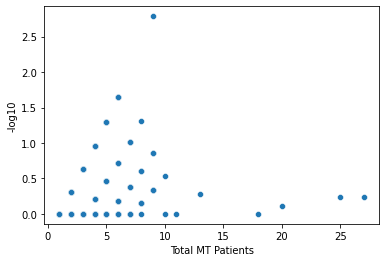

In [99]:
# Scatter plot of results from Fisher's 
sns.scatterplot(data=gene_enrichment_table, x='Total MT Patients', y='-log10')